In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from string import punctuation
#text preprocessing libraries
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
# Importing Layers, Sequential Model, Feature Extraction, Text Pre-processing, Tokenizer
from tensorflow import keras
import tensorflow as tf
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
# Preprocessing Text with Keras
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Getting Train Test Split
from sklearn.model_selection import train_test_split
# Importing metric libraries
from sklearn.metrics import confusion_matrix,classification_report,cohen_kappa_score, accuracy_score
# One-hot encoding, utilities, visualisation
from keras.utils import to_categorical
from keras import utils
from keras.utils import plot_model
# LSTM Layers, Sequential Layers, Embedding, Dense Layers, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, GlobalMaxPooling1D, Flatten, MaxPooling1D,GRU,Bidirectional,Activation
from keras.models import Sequential

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/TwitterHate.csv")

In [ ]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# check target value imbalance
df["label"].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

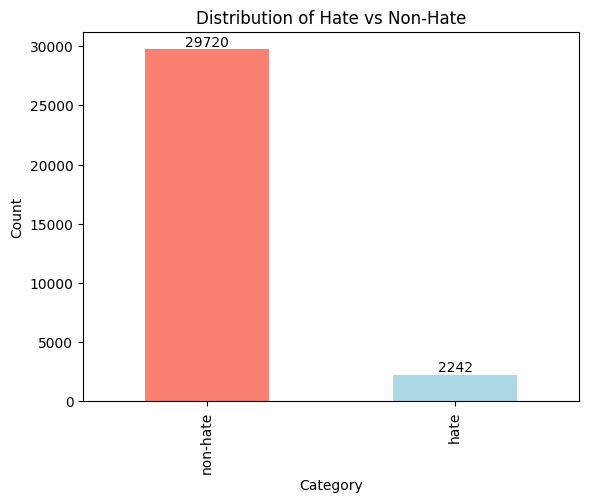

In [ ]:

# Map labels
label_map = {0: "non-hate", 1: "hate"}
ax = df.label.map(label_map).value_counts().plot(kind="bar", color=["salmon", "lightblue"])
for i, count in enumerate(df.label.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
# Set labels for x-axis ticks
plt.xticks(range(len(label_map)), [label_map[i] for i in range(len(label_map))])

# Set plot title and labels
plt.title("Distribution of Hate vs Non-Hate")
plt.xlabel("Category")
plt.ylabel("Count")

# Show plot
plt.show()


In [ ]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


In [ ]:
#get rid of the identifier number of the tweet
df.drop('id',axis=1,inplace=True)

In [ ]:
#view one of the tweets randomly
random = np.random.randint(0,len(df))
print(random)
df.iloc[random]['tweet']

27222


'an old acquaintance found murdered back home. the attack in orlando. the mass murder in roswell. not even mentioning anywhere else.  '

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Apply oversampling to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Create a new dataframe with the resampled data
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['label'] = y_resampled

# Concatenate the original dataframe with the resampled dataframe
df = pd.concat([df, resampled_df], ignore_index=True)

In [ ]:
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
resampled_df["label"].value_counts()

label
0    29720
1    29720
Name: count, dtype: int64

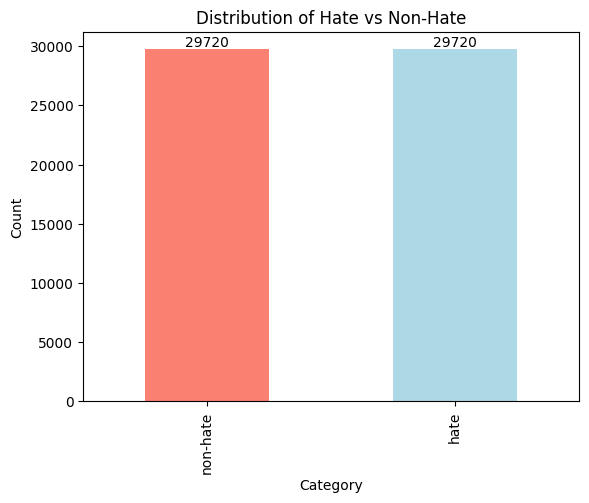

In [ ]:

# Map labels
label_map = {0: "non-hate", 1: "hate"}
ax = resampled_df.label.map(label_map).value_counts().plot(kind="bar", color=["salmon", "lightblue"])
for i, count in enumerate(resampled_df.label.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
# Set labels for x-axis ticks
plt.xticks(range(len(label_map)), [label_map[i] for i in range(len(label_map))])

# Set plot title and labels
plt.title("Distribution of Hate vs Non-Hate")
plt.xlabel("Category")
plt.ylabel("Count")

# Show plot
plt.show()



In [ ]:
# Define a preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove user handles
    text = re.sub(r'@[^\s]+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    preprocessed_text = ' '.join(filtered_tokens)

    # Return preprocessed text
    return preprocessed_text

# Apply preprocessing to the 'tweet' column
df['tweet'] = df['tweet'].apply(preprocess_text)

# Combine all preprocessed tweets into a single string
all_tweets = ' '.join(df['tweet'])

# Tokenization
preprocessed_tokens = word_tokenize(all_tweets)

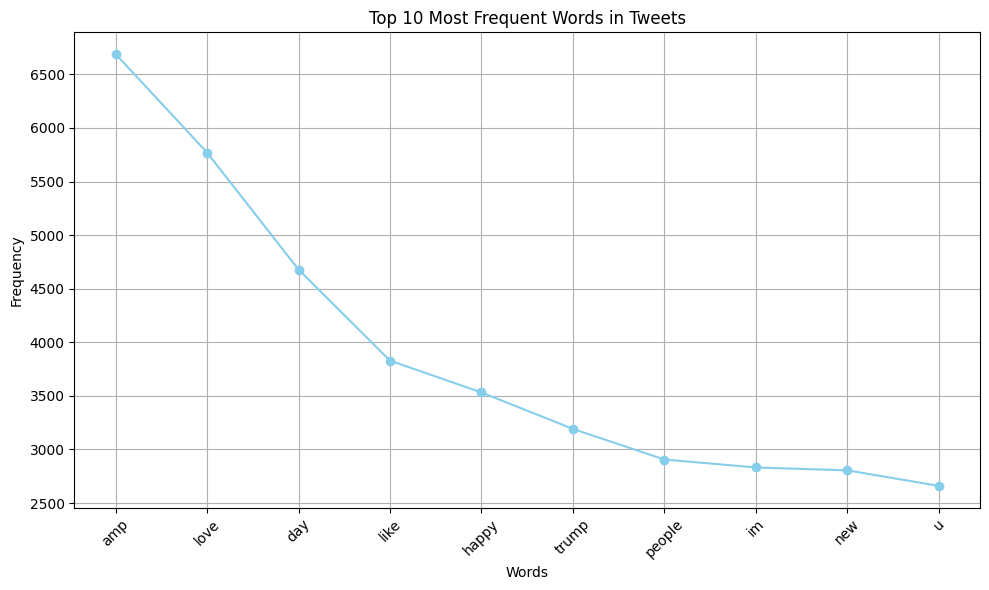

In [ ]:
from collections import Counter
# Count the frequency of each word
word_freq = Counter(preprocessed_tokens)

# Sort the word frequencies
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

# Extract words and frequencies for plotting
words = list(sorted_word_freq.keys())[:10]
frequencies = list(sorted_word_freq.values())[:10]

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(words, frequencies, marker='o', color='skyblue', linestyle='-')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:

#apply spelling correction on a sample text
from textblob import TextBlob
sample = 'amazng man you did it finallyy'
txtblob = TextBlob(sample)
corrected_text = txtblob.correct()
print(corrected_text)

amazing man you did it finally


In [ ]:
#textblob expect a string to be passed and not a list of strings
from textblob import TextBlob

def spell_check(X_resampled):
    '''Function to do spelling correction using '''
    txtblob = TextBlob(X_resampled)
    corrected_text = txtblob.correct()
    return corrected_text


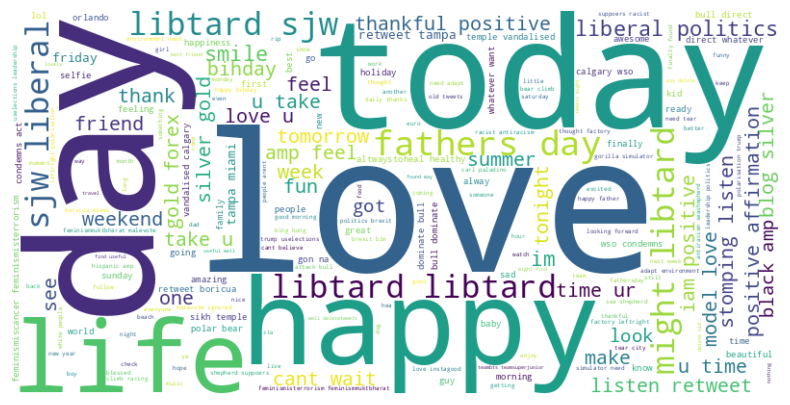

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all tweets into a single string
all_tweets = ' '.join(df['tweet'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_tweets)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


<h1>DEEP LEARNING MODELLING PHASE</h1>

In [ ]:
# Model Hyper-Parameters
max_vocab = 10000
max_len = 256
epochs = 10
emb_dim = 300
batch_size = 256
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list =[early_stopping]

## Define X and y from train data for use in tokenization by Vectorizers

In [ ]:
from tensorflow import keras

# Split Between Variables into Input & Target Variable
X = resampled_df.tweet

y = resampled_df.label

# Converting One-hot Encoding Categorical Data
labels = keras.utils.to_categorical(y,num_classes=2)

label_list = ['non-hate', 'hate']


In [ ]:
# Define a preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove user handles
    text = re.sub(r'@[^\s]+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Return preprocessed tokens
    return filtered_tokens

# Apply preprocessing to the 'tweet' column
X = X.apply(preprocess_text)
# Get all preprocessed tokens
X = X.tolist()
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_vocab, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

# Fit Tokenizer on preprocessed tokens
tokenizer.fit_on_texts(X)
# Convert Text to Sequences of Texts
sequences = tokenizer.texts_to_sequences(X)
# Get word Index from Tokenizer
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# Pad Sequences so They are of a Fixed Length
padded_sequences = pad_sequences(sequences, maxlen=max_len)

Found 39588 unique tokens.


In [ ]:
vocab = len(word_index)

In [ ]:
# The sentence
print("The sentence before they are trasnformed into sequences: " + df.tweet[1])

print("\t")
# The Sequence
print("The sentences transformed into sequences: "+ str(sequences[1]))

print("\t")
# The Padded Sequence
print("The sentences padded to be of the same length: " + str(padded_sequences[1]))

The sentence before they are trasnformed into sequences: thanks lyft credit cant use cause dont offer wheelchair vans pdx disapointed getthanked
	
The sentences transformed into sequences: [65, 8414, 3183, 20, 209, 754, 13, 1955]
	
The sentences padded to be of the same length: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0 

In [ ]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences , labels, test_size=0.20, random_state=42)

In [ ]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((47552, 256), (47552, 2), (11888, 256), (11888, 2))


In [ ]:
X_train

array([[   0,    0,    0, ...,  830, 1969,    1],
       [   0,    0,    0, ...,   32,   49, 4131],
       [   0,    0,    0, ..., 1926,   88, 7295],
       ...,
       [   0,    0,    0, ...,   97,  116,  348],
       [   0,    0,    0, ...,    1,  976,  162],
       [   0,    0,    0, ...,  119,  336, 3347]], dtype=int32)

In [ ]:
y_test

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
# Model Type Initialisation
lstm_model = Sequential()
# Input Layer
lstm_model.add(Embedding(vocab, emb_dim, input_length=padded_sequences.shape[1]))
# Hidden Layer
lstm_model.add(SpatialDropout1D(0.5))
lstm_model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.7))
# Output Layer
lstm_model.add(Dense(2, activation='softmax'))

# Model Compiler
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Model Summary
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          11876400  
                                                                 
 spatial_dropout1d (Spatial  (None, 256, 300)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 11969970 (45.66 MB)
Trainable params: 11969970 (45.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
Architecture  = plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%time
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                         validation_split=0.2,callbacks=callbacks_list,shuffle=True)

Epoch 1/10
149/149 [==============================] - 472s 3s/step - loss: 0.2845 - acc: 0.8787 - val_loss: 0.0916 - val_acc: 0.9675
Epoch 2/10
149/149 [==============================] - 463s 3s/step - loss: 0.0670 - acc: 0.9773 - val_loss: 0.0491 - val_acc: 0.9841
Epoch 3/10
149/149 [==============================] - 498s 3s/step - loss: 0.0347 - acc: 0.9893 - val_loss: 0.0382 - val_acc: 0.9890
Epoch 4/10
149/149 [==============================] - 464s 3s/step - loss: 0.0230 - acc: 0.9926 - val_loss: 0.0346 - val_acc: 0.9902
Epoch 5/10
149/149 [==============================] - 480s 3s/step - loss: 0.0168 - acc: 0.9947 - val_loss: 0.0475 - val_acc: 0.9865
Epoch 6/10
149/149 [==============================] - 467s 3s/step - loss: 0.0129 - acc: 0.9954 - val_loss: 0.0464 - val_acc: 0.9881
Epoch 7/10
 24/149 [===>..........................] - ETA: 6:14 - loss: 0.0126 - acc: 0.9958

In [ ]:
# Determining Accuracy of the LSTM model
accr = lstm_model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

372/372 [==============================] - 32s 85ms/step - loss: 0.0429 - acc: 0.9889
Test set
  Loss: 0.0429
  Accuracy: 0.9889


In [ ]:
# Using LSTM to generate predictions on the test set
predictions = lstm_model.predict(x= X_test, batch_size = 10, verbose = 1)

1189/1189 [==============================] - 67s 56ms/step


In [ ]:
# Rounding the predictions to generate the labels
rounded_predictions = np.argmax(predictions,axis=-1)

# Making sure predictions are transformed into labels
rounded_predictions

# Rounding the labels used generate the labels
rounded_labels = np.argmax(y_test,axis=-1)

# Making sure labels are transformed into labels
rounded_labels

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
# Turning the rounded predictions into a dataframe
labels_pred = pd.DataFrame(rounded_predictions)
labels_pred.shape
y_test_sorted = np.argmax(y_test,axis=-1)

# Generate Confusion Matrix
cm = confusion_matrix(y_true=rounded_labels,y_pred=rounded_predictions)

# Generate and Print Classification Report
classifcation_rep = (classification_report(y_test_sorted,rounded_predictions))
print("LSTM Classification Report")
print(classifcation_rep)

LSTM Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5892
           1       0.98      1.00      0.99      5996

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



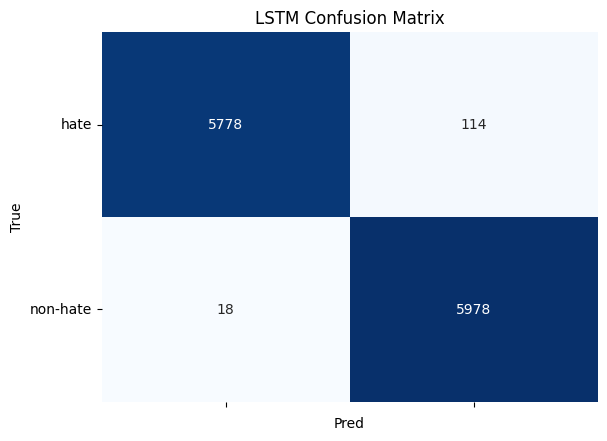

In [ ]:
# Initialise class names
classes = np.unique(label_list)

# Display Confusion Matrix using Matplotlib

cm = confusion_matrix(y_test_sorted, rounded_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True",xticklabels='',yticklabels=classes
       ,title="LSTM Confusion Matrix")
plt.yticks(rotation=0)
plt.show()


<ipython-input-39-bd92c1eea6ef>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
<ipython-input-39-bd92c1eea6ef>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')


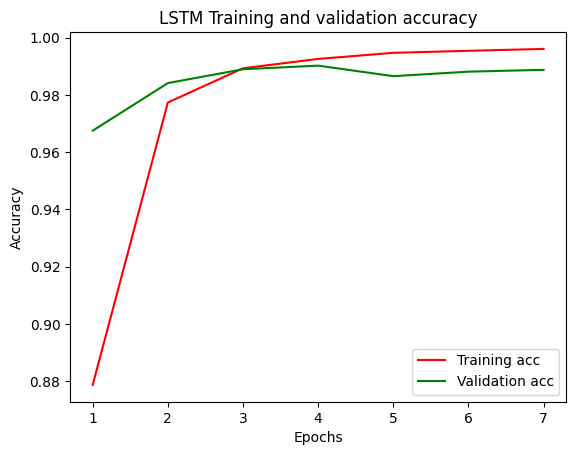

<ipython-input-39-bd92c1eea6ef>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b',color='red', label='Training loss')
<ipython-input-39-bd92c1eea6ef>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')


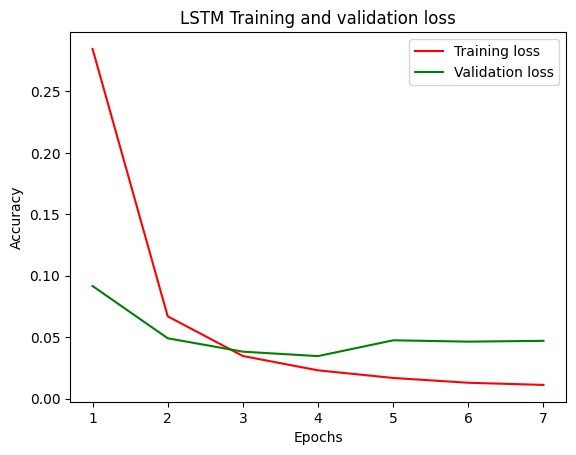

In [ ]:

# Comparing training and validation accuracy

%matplotlib inline


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b',  color='red', label='Training acc')
plt.plot(epochs, val_acc, 'b',color='green', label='Validation acc')
plt.title('LSTM Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

plt.plot(epochs, loss, 'b',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='green' ,label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
X_test

array([[   0,    0,    0, ...,    2, 2031, 8443],
       [   0,    0,    0, ...,  111,   39, 5651],
       [   0,    0,    0, ..., 3625, 4412,   41],
       ...,
       [   0,    0,    0, ..., 1779, 1014, 3472],
       [   0,    0,    0, ...,  486,  140,  278],
       [   0,    0,    0, ..., 9615, 9971,  187]], dtype=int32)

In [ ]:
predictin

array([[0.9888787 , 0.01112128]], dtype=float32)

In [ ]:
#Hate speech classification system
def preprocess_single_text(text):
    # Lowercasing
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user handles
    text = re.sub(r'@[^\s]+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Return preprocessed tokens as a single string
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text
# Preprocess the single input
single_input_text = "@i love you"
preprocessed_input = preprocess_single_text(single_input_text)

# Tokenize and pad the preprocessed input
input_sequence = tokenizer.texts_to_sequences([preprocessed_input])
padded_input_sequence = pad_sequences(input_sequence, maxlen=max_len)

# Use the LSTM model to predict the label
prediction = lstm_model.predict(padded_input_sequence)

# Rounding the prediction to get the class label
predicted_class_index = np.argmax(prediction)

# Output the predicted class
if predicted_class_index == 0:
    print("Predicted Class: Non-hate Speech")
else:
    print("Predicted Class: Hate Speech")


1/1 [==============================] - 0s 90ms/step
Predicted Class: Non-hate Speech
